In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import MSTL

In [13]:
neft_data = pd.read_excel('D:\Personal\Education\PGDBA 2023-25\Sem1\SPA\TimeSeries Project\Payment Systems Volume Payment Transactions RBI Operated National Electronic Funds Transfer NEFT.xlsx')[:-7]

# Functions

In [14]:
def evaluate_stationarity(dataset):
    result = adfuller(dataset)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Preprocessing

In [15]:
neft_data['Date'] = neft_data['Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%d-%m  00:00:00') if isinstance(x, str) else x)
neft_data['Date'] = pd.to_datetime(neft_data['Date'], format='%Y-%d-%m %H:%M:%S')
neft_data.rename(columns = {"Payment Volume (Unit mn)": "Volume"}, inplace = True)
print(neft_data)

           Date     Volume
0    2020-06-01  17.211000
1    2020-06-02  10.006772
2    2020-06-03  10.036426
3    2020-06-04   9.465655
4    2020-06-05  11.126259
...         ...        ...
1252 2023-11-05  11.863879
1253 2023-11-06  25.645393
1254 2023-11-07  30.939605
1255 2023-11-08  30.113271
1256 2023-11-09  28.903590

[1257 rows x 2 columns]


# EDA

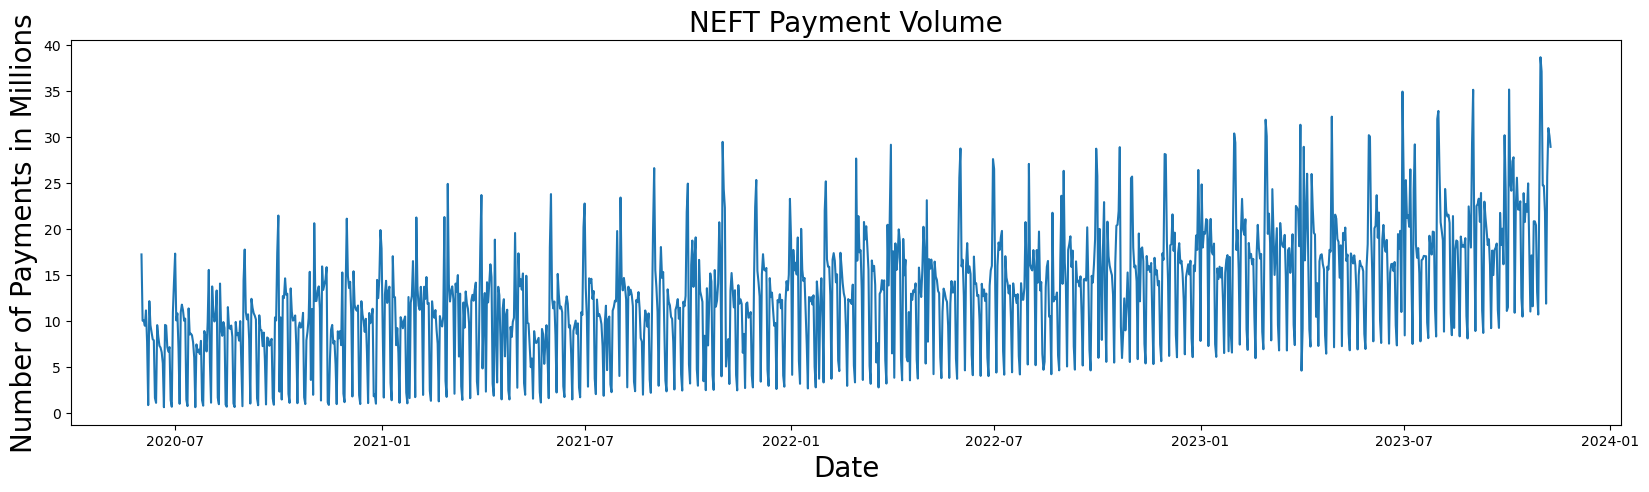

In [16]:
#Plot Entire Graph
plt.figure(figsize=(20,5))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Payments in Millions', fontsize=20)
plt.title('NEFT Payment Volume', fontsize=20)
plt.plot(neft_data['Date'], neft_data['Volume'])

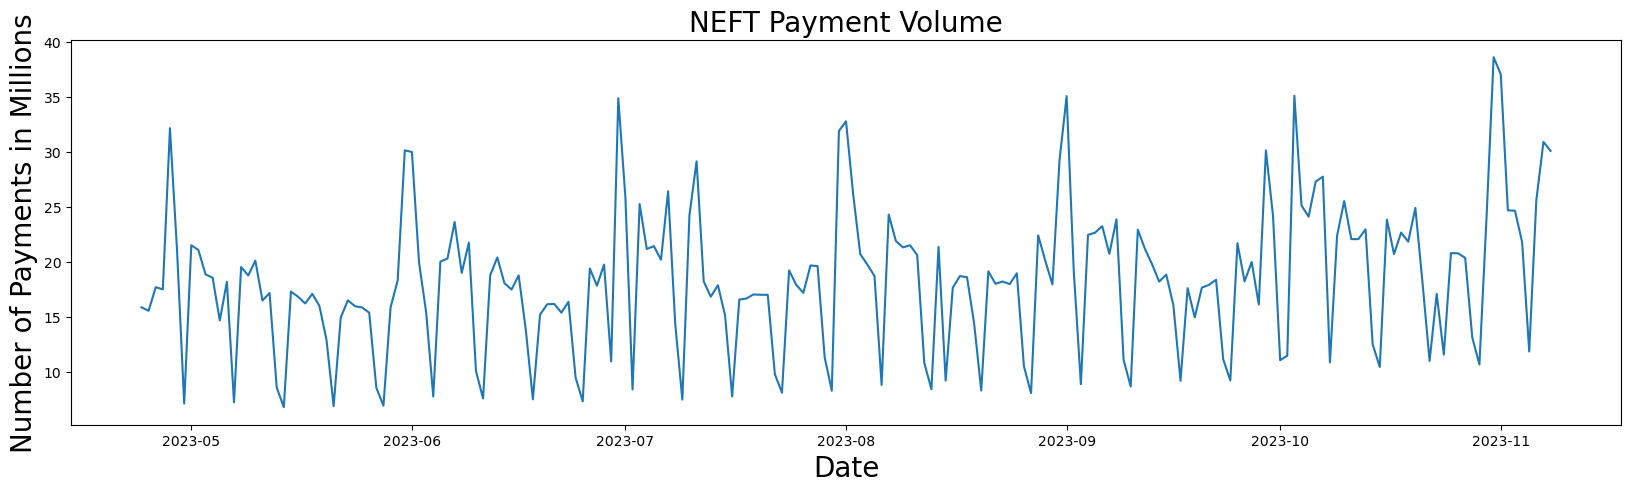

In [17]:
#Plot A Sub-Section
plt.figure(figsize=(20,5))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Payments in Millions', fontsize=20)
plt.title('NEFT Payment Volume', fontsize=20)
neft_data_last_200 = neft_data[-200:-1]
plt.plot(neft_data_last_200['Date'], neft_data_last_200['Volume'])

In [18]:
#Train Test Split
neft_test = neft_data[-30:-1]
neft_train = neft_data[0:len(neft_data) - 30]

In [19]:
evaluate_stationarity(neft_train['Volume'])

ADF Statistic: -2.434490
p-value: 0.132238
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


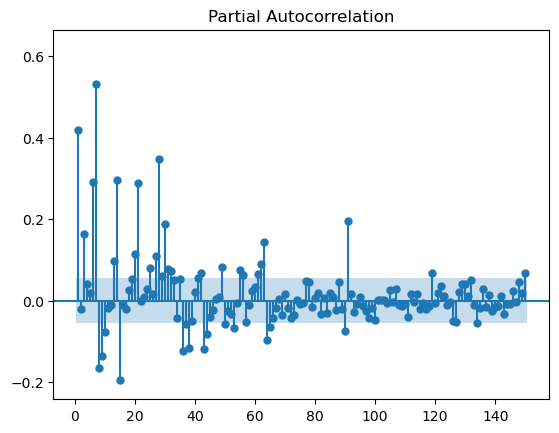

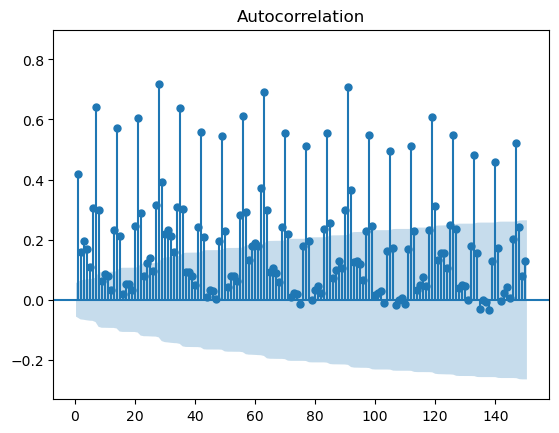

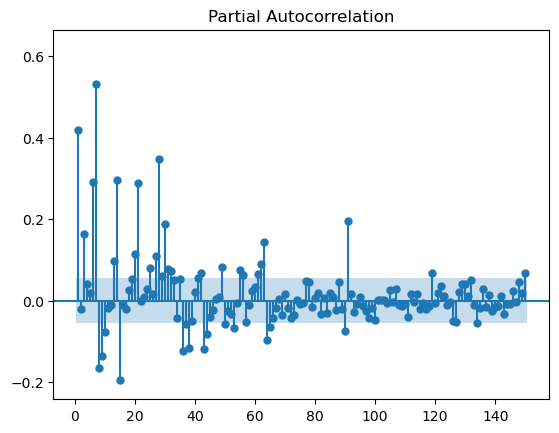

In [20]:
plot_acf(neft_train['Volume'], lags=150, zero=False, auto_ylims=True)
plot_pacf(neft_train['Volume'], lags=150, zero=False, auto_ylims=True)

Presence of a seasonality of 7 confirmed from the ACF Plot

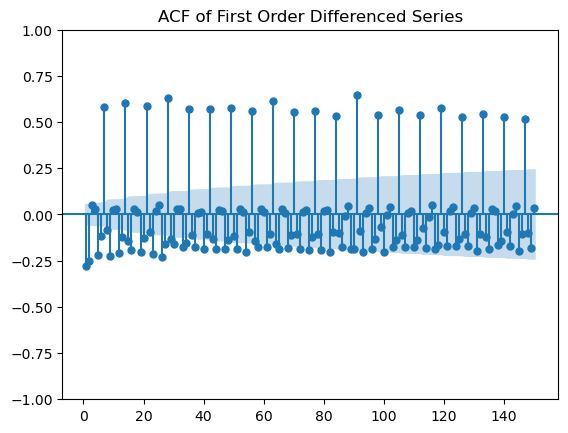

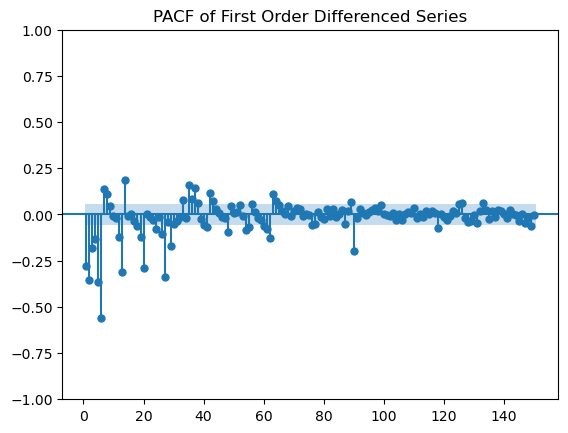

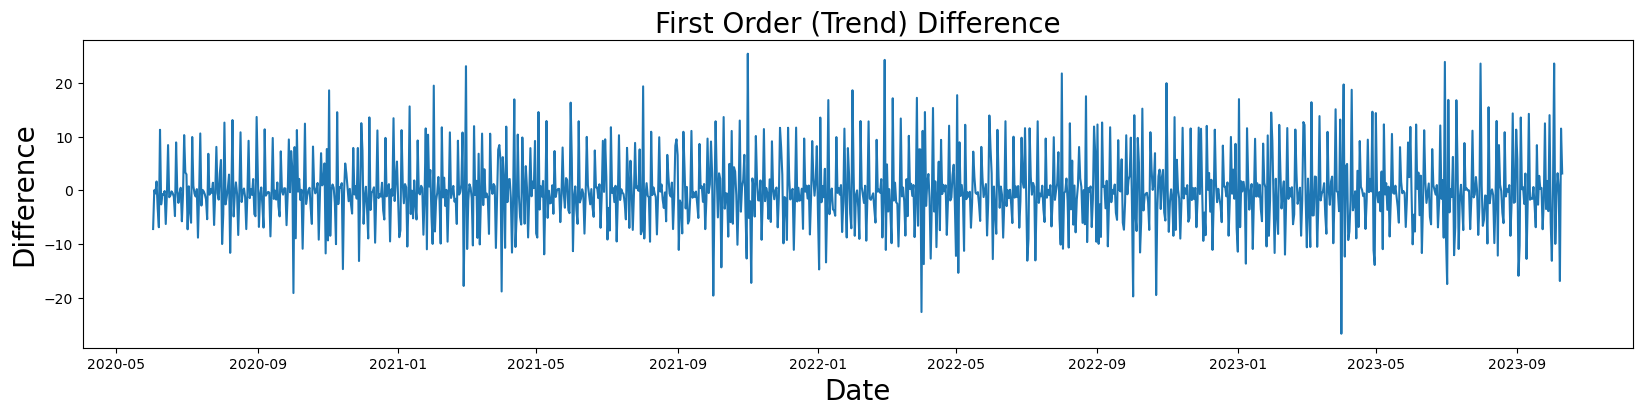

In [21]:
seasonality_period = 1

neft_train_1diff = pd.DataFrame()
neft_train_1diff['Date'] = neft_train['Date'][seasonality_period:]
neft_train_1diff['Volume'] = neft_train['Volume'].diff(seasonality_period)[seasonality_period:]

plot_acf(neft_train_1diff['Volume'], lags=150, zero=False, title='ACF of First Order Differenced Series')
plot_pacf(neft_train_1diff['Volume'], lags=150, zero=False, title='PACF of First Order Differenced Series')

# evaluate_stationarity(neft_train_1diff['Volume'])

plt.figure(figsize=(20,4))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Difference', fontsize=20)
plt.title('First Order (Trend) Difference', fontsize=20)
plt.plot(neft_train_1diff['Date'], neft_train_1diff['Volume'])

ADF Statistic: -14.562303
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


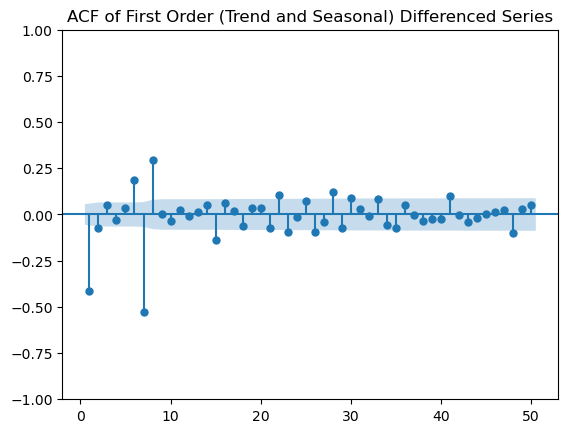

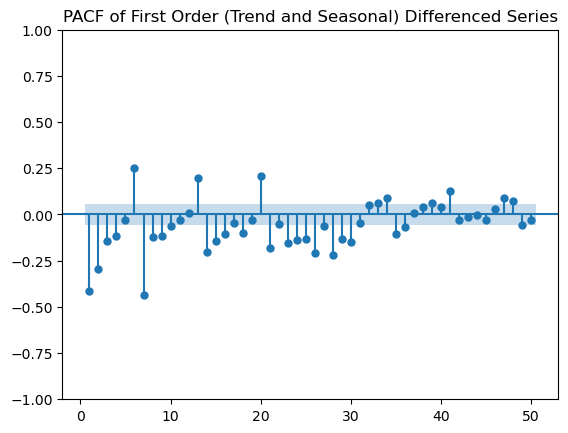

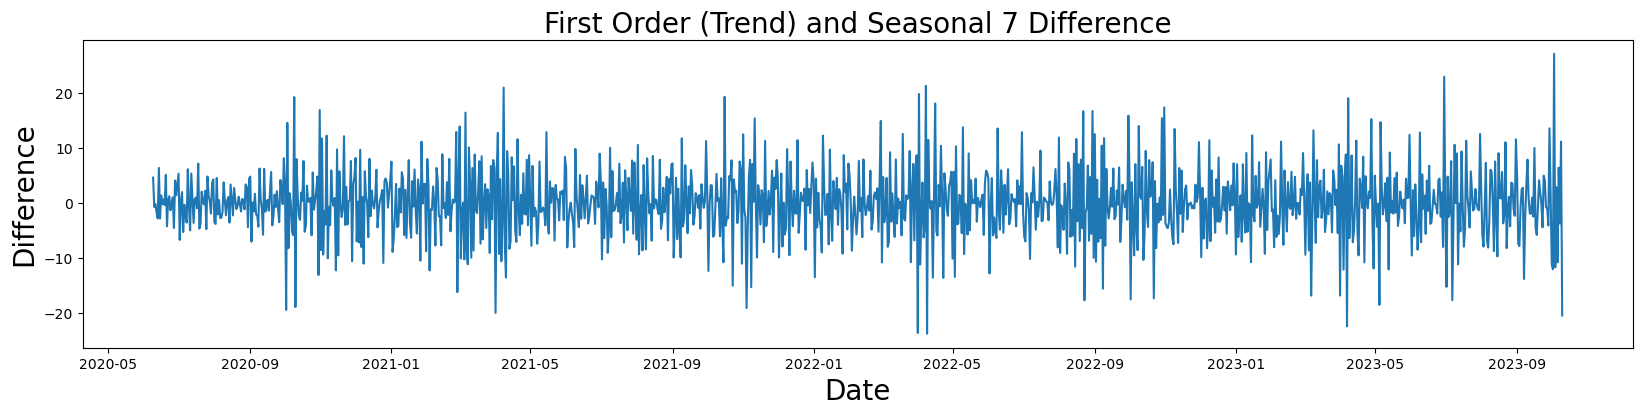

In [22]:
seasonality_period = 7

neft_train_1_7diff = pd.DataFrame()
neft_train_1_7diff['Date'] = neft_train_1diff['Date'][seasonality_period:]
neft_train_1_7diff['Volume'] = neft_train_1diff['Volume'].diff(seasonality_period)[seasonality_period:]

plot_acf(neft_train_1_7diff['Volume'], lags=50, zero=False, title='ACF of First Order (Trend and Seasonal) Differenced Series')
plot_pacf(neft_train_1_7diff['Volume'], lags=50, zero=False, title='PACF of First Order (Trend and Seasonal) Differenced Series')

evaluate_stationarity(neft_train_1_7diff['Volume'])

plt.figure(figsize=(20,4))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Difference', fontsize=20)
plt.title('First Order (Trend) and Seasonal 7 Difference', fontsize=20)
plt.plot(neft_train_1_7diff['Date'], neft_train_1_7diff['Volume'])

## SARIMA with non-seasonal difference 1 and seasonal difference 1 (seasonality 7)

We observe that,
Non-seasonal components

AR - 1
Difference - 1
MA - 1/2

Seasonal Components (Seasonality 7)

AR - 3/4
Difference - 1
MA - 1/2

In [25]:
import itertools

p = list(range(1, 2))
d = list(range(1, 2))
q = list(range(1, 3))

P = list(range(1, 5))
D = list(range(1, 2))
Q = list(range(1, 2))

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, D, Q))]
model_evaluation = pd.DataFrame(columns = ['Description', 'AIC'], index = range(0, len(pdq)*len(seasonal_pdq)))
print('Examples of parameter combinations for Seasonal ARIMA...')
index = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            model_evaluation.loc[index].Description = "ARIMA{}x{}".format(param, param_seasonal)
            model_evaluation.loc[index].AIC = results.aic
            index += 1
        except Exception as e:
            print("Exception: {}".format(e))
            break

Examples of parameter combinations for Seasonal ARIMA...
ARIMA(1, 1, 1)x(1, 1, 1, 7) - AIC:6568.299355145831
ARIMA(1, 1, 1)x(2, 1, 1, 7) - AIC:6529.825980673319
ARIMA(1, 1, 1)x(3, 1, 1, 7) - AIC:6489.367188678412
ARIMA(1, 1, 1)x(4, 1, 1, 7) - AIC:6427.056429264936
ARIMA(1, 1, 2)x(1, 1, 1, 7) - AIC:6551.026555035055


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 1, 7) - AIC:6522.787110754196
ARIMA(1, 1, 2)x(3, 1, 1, 7) - AIC:6485.752510093347


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(4, 1, 1, 7) - AIC:6430.216214455448


In [26]:
print(model_evaluation.sort_values('AIC'))

                   Description          AIC
3  ARIMA(1, 1, 1)x(4, 1, 1, 7)  6427.056429
7  ARIMA(1, 1, 2)x(4, 1, 1, 7)  6430.216214
6  ARIMA(1, 1, 2)x(3, 1, 1, 7)   6485.75251
2  ARIMA(1, 1, 1)x(3, 1, 1, 7)  6489.367189
5  ARIMA(1, 1, 2)x(2, 1, 1, 7)  6522.787111
1  ARIMA(1, 1, 1)x(2, 1, 1, 7)  6529.825981
4  ARIMA(1, 1, 2)x(1, 1, 1, 7)  6551.026555
0  ARIMA(1, 1, 1)x(1, 1, 1, 7)  6568.299355


In [27]:
#Potential models
# ARIMA(0, 1, 0)x(0, 1, 2, 7) - AIC:7037.79434227292
# ARIMA(0, 1, 0)x(1, 1, 2, 7) - AIC:7037.184201915846


# mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
#             order=[0, 1, 1],
#             seasonal_order=[0, 1, 1, 7],
#             enforce_stationarity=False,
#             enforce_invertibility=False)
# results = mod.fit()

# # future_forecast = mod.predict(n_periods=40)
# print(results.summary())

#Potential models
# ARIMA(0, 1, 0)x(0, 1, 2, 7) - AIC:7037.79434227292
# ARIMA(0, 1, 0)x(1, 1, 2, 7) - AIC:7037.184201915846


# mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
#             order=[1, 1, 1],
#             seasonal_order=[3, 1, 2, 7],
#             enforce_stationarity=False,
#             enforce_invertibility=False)
# results = mod.fit()

# # future_forecast = mod.predict(n_periods=40)
# print(results.summary())

In [28]:
mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
            order=[1, 1, 1],
            seasonal_order=[3, 1, 1, 7],
            enforce_stationarity=False,
            enforce_invertibility=False)
results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                 1227
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -3237.684
Date:                           Wed, 13 Dec 2023   AIC                           6489.367
Time:                                   00:13:40   BIC                           6524.980
Sample:                                        0   HQIC                          6502.784
                                          - 1227                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2950      0.020     14.997      0.000       0.256       0.334
ma.L1         -0.9929      0.006   -173.480

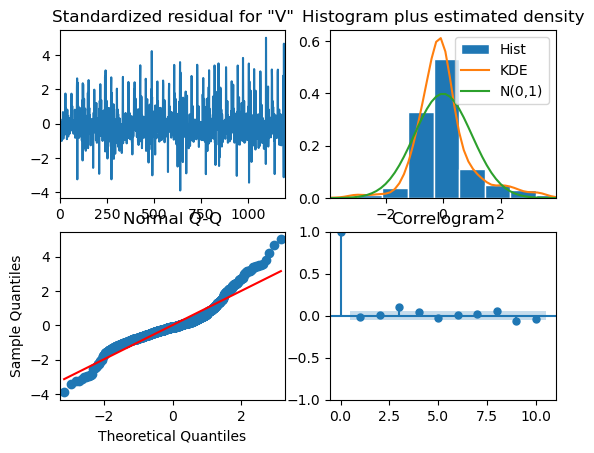

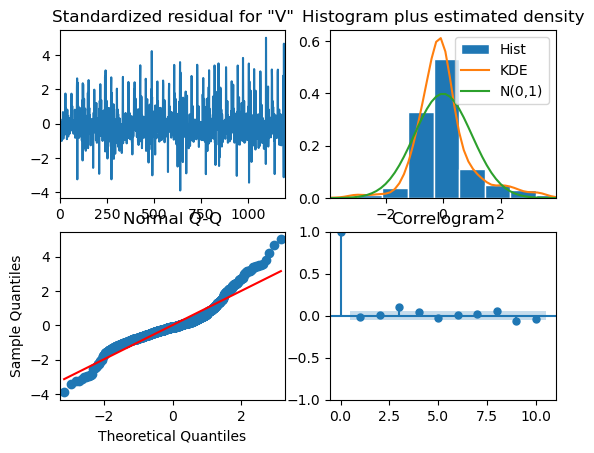

In [29]:
results.plot_diagnostics()

In [30]:
# print(neft_train)
predictions = results.predict(start = 1234, end = 1275)
# print(predictions)
full_prediction = results.predict()

MAE: 4.73
MSE: 42.24
RMSE: 6.50
MAPE: 20.52%
sMAPE: 21.79%


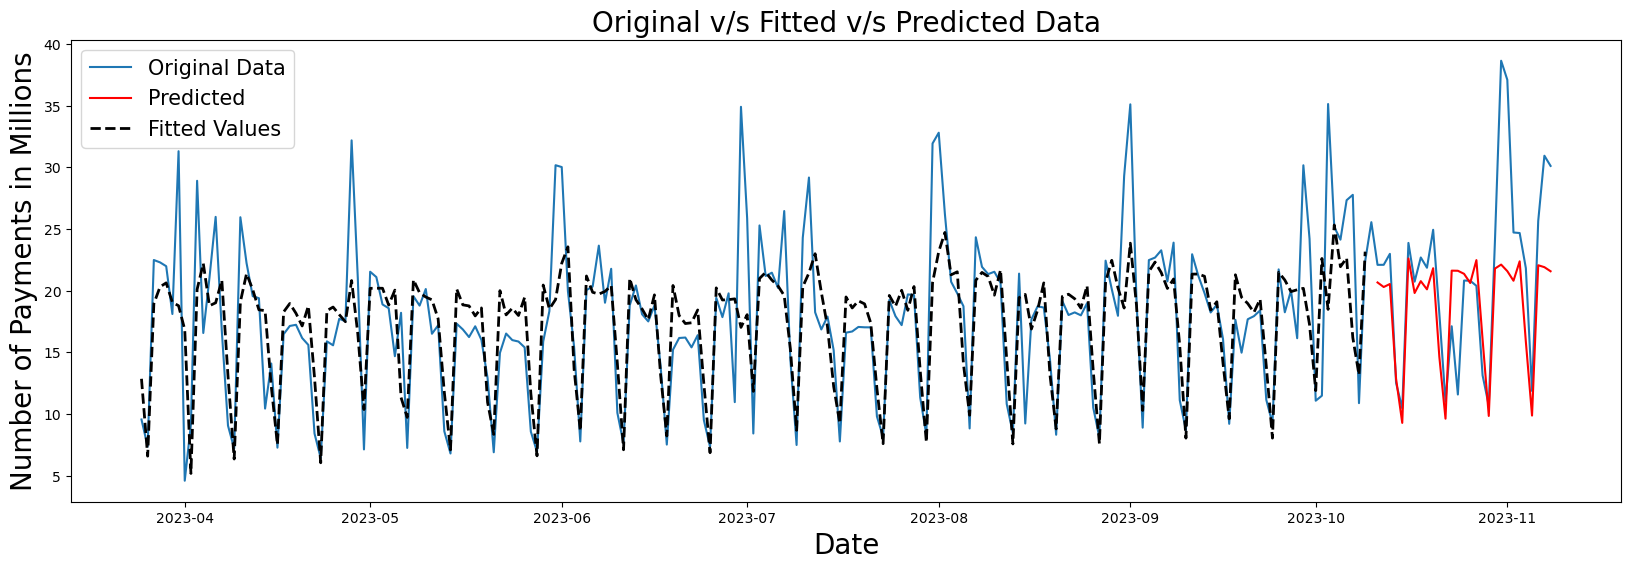

In [31]:
plt.figure(figsize=(20,6))


plt.title("Original v/s Fitted v/s Predicted Data", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of Payments in Millions", fontsize=20)
plt.plot(neft_data['Date'][-230:-1], neft_data['Volume'][-230:-1], label="Original Data")

plt.plot(neft_test['Date'][:29], predictions[:29], color='red', label="Predicted")
plt.plot(neft_train['Date'][-200:-1], full_prediction[-200:-1], color='black', linestyle='dashed', linewidth=2, label="Fitted Values")
plt.legend(loc="upper left", fontsize = 15)

# Calculate errors
errors = neft_test.Volume - predictions
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / neft_test.Volume)) * 100
smape = np.mean(2 * np.abs(errors) / (np.abs(neft_test.Volume) + np.abs(predictions))) * 100

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')


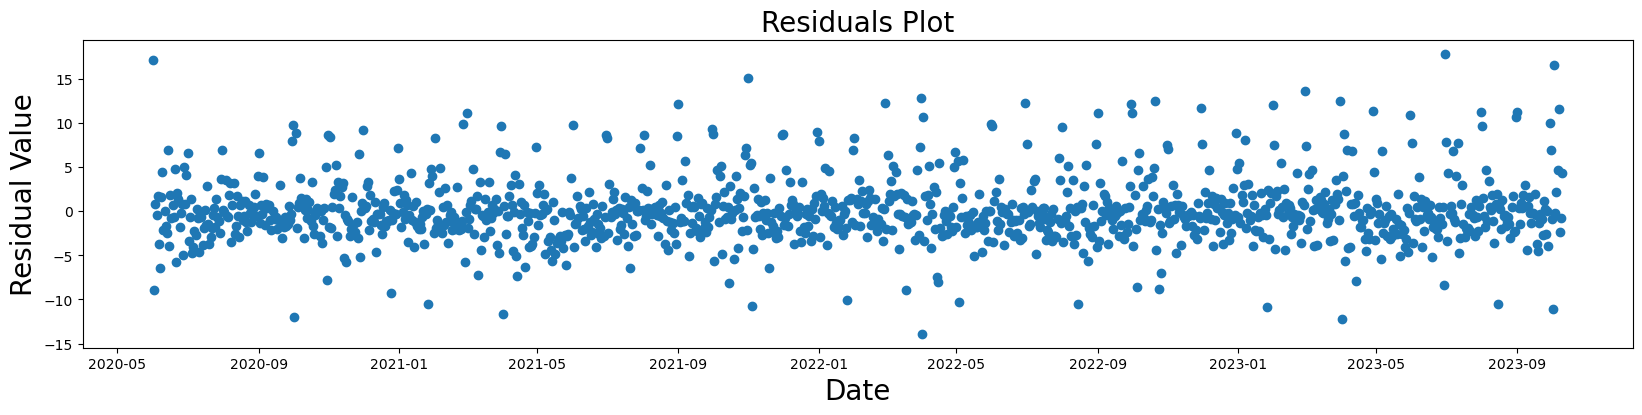

In [32]:
plt.figure(figsize=(20,4))
plt.title("Residuals Plot", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Residual Value", fontsize=20)
plt.scatter(neft_train['Date'], results.resid)

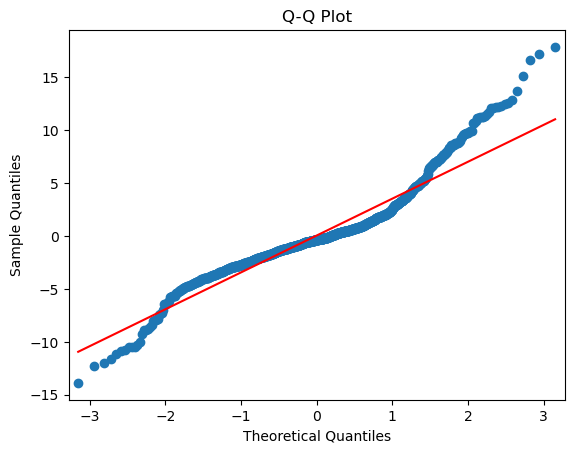

In [33]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(results.resid, line='r')
plt.title("Q-Q Plot")
plt.show()

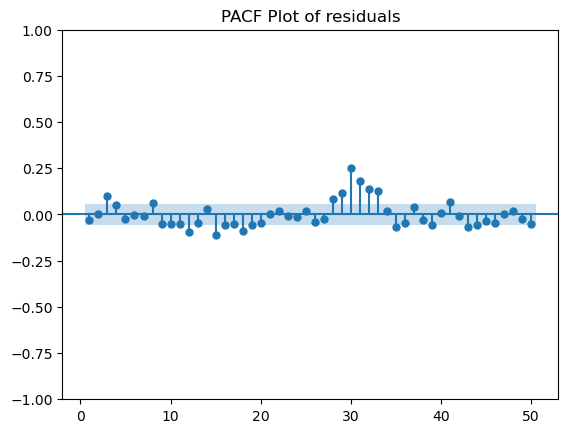

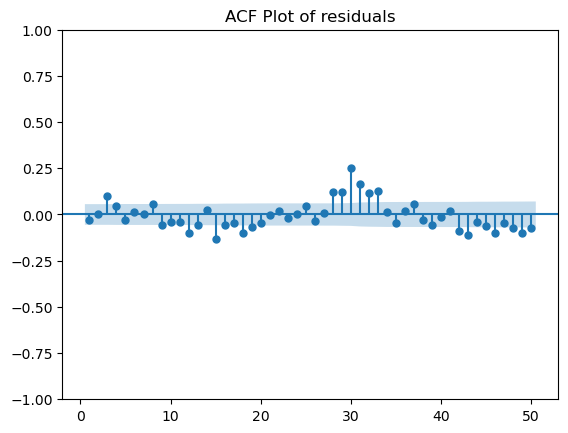

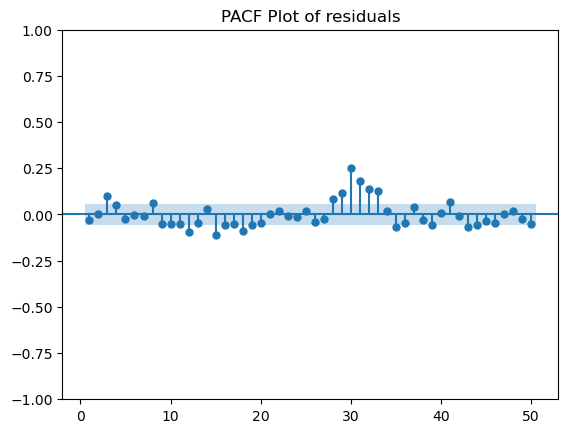

In [34]:
plot_acf(results.resid, lags=50, zero=False, title="ACF Plot of residuals")
plot_pacf(results.resid, lags=50, zero=False, title="PACF Plot of residuals")

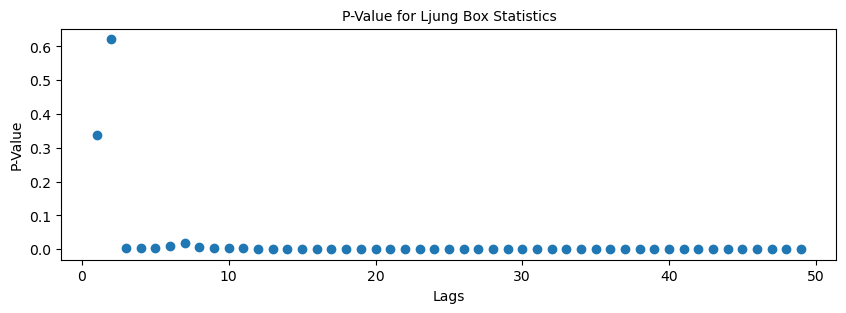

In [35]:
plt.figure(figsize = (10, 3))
plt.title("P-Value for Ljung Box Statistics", fontsize=10)
plt.xlabel("Lags", fontsize=10)
plt.ylabel("P-Value", fontsize=10)
plt.scatter(range(0, 50), sm.stats.acorr_ljungbox(results.resid, lags=range(0, 50), return_df=True).lb_pvalue)

# MSTL Decomposition


In [36]:
stl_kwargs = {"seasonal_deg": 0}
model = MSTL(neft_train['Volume'], periods=(7, 30), stl_kwargs=stl_kwargs)
res = model.fit()

In [37]:
seasonal = res.seasonal # contains both seasonal components
trend = res.trend
residual = res.resid
weigths = res.weights

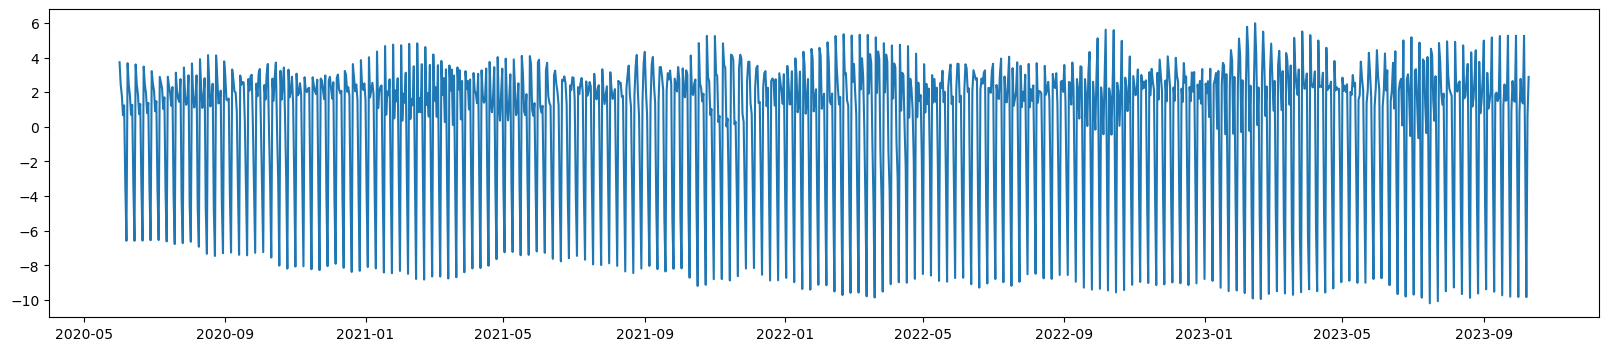

In [38]:
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonal.seasonal_7)

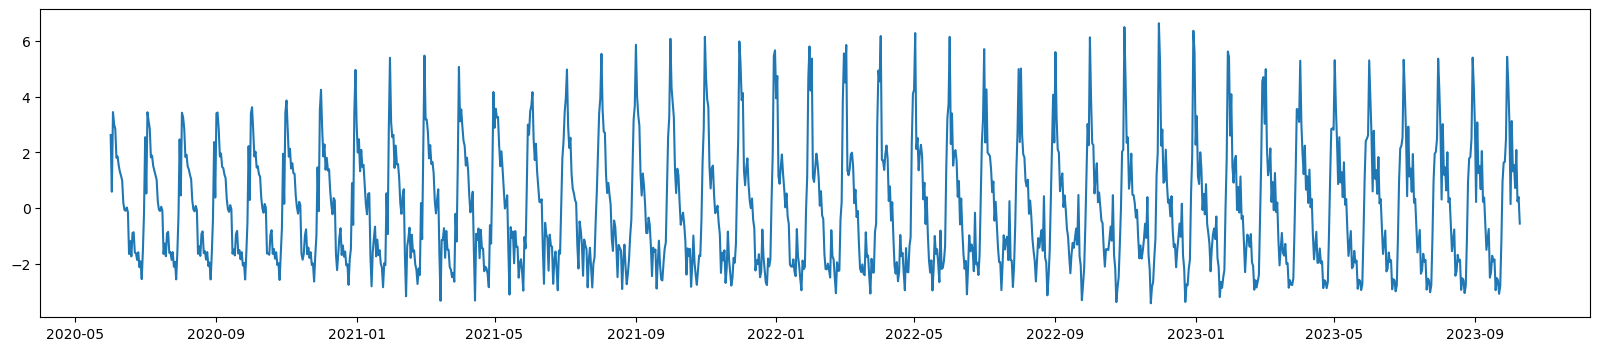

In [39]:
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonal.seasonal_30)

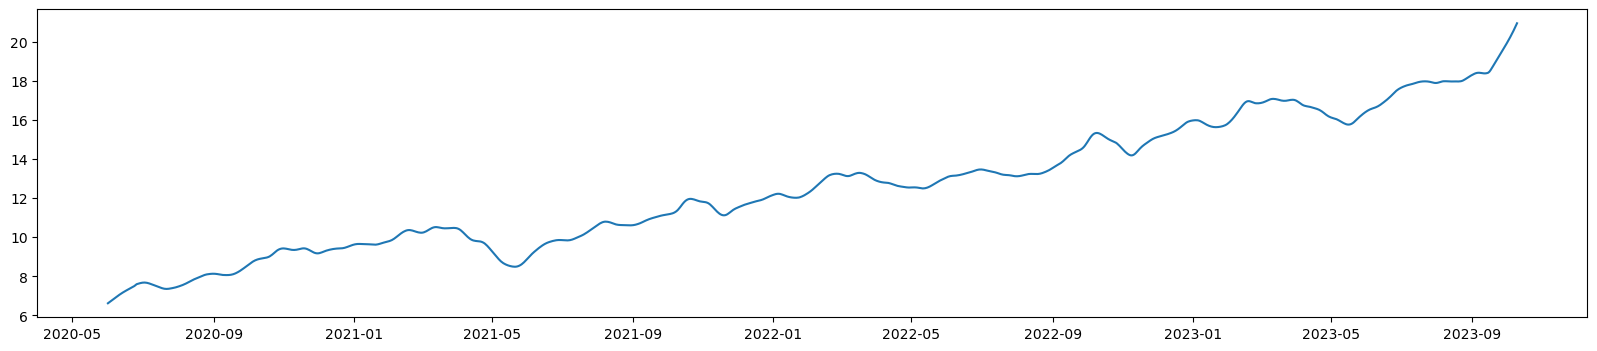

In [40]:
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], trend)

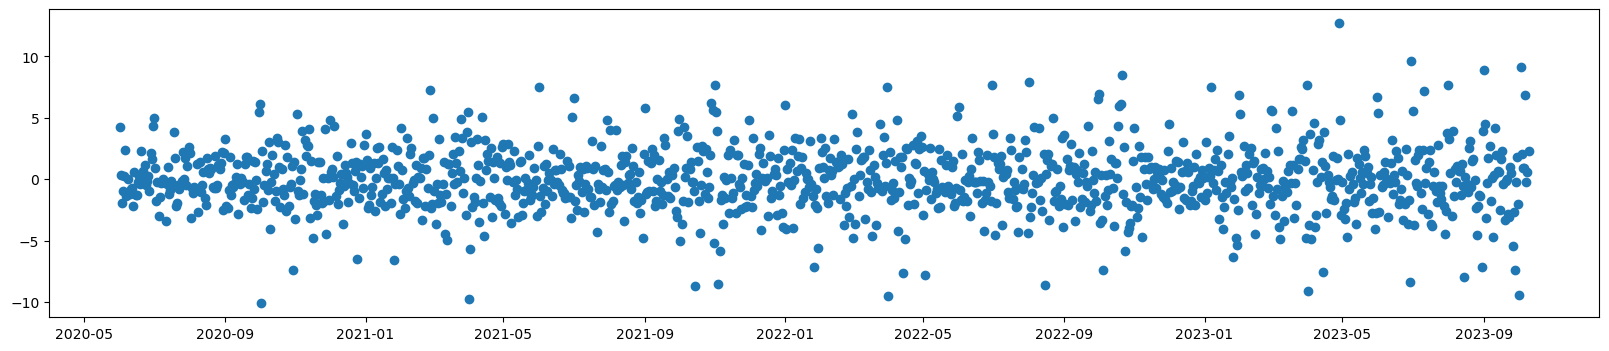

In [41]:
plt.figure(figsize=(20,4))
plt.scatter(neft_train['Date'], residual)

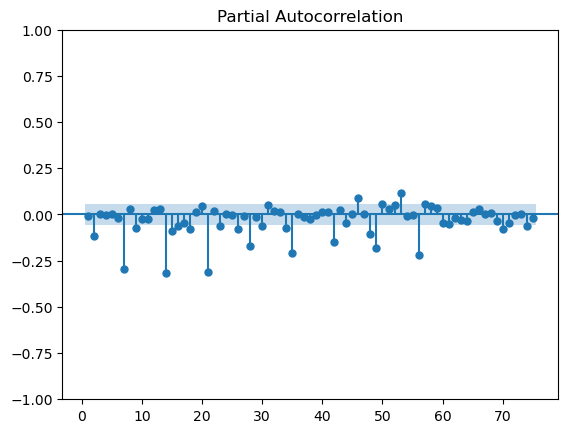

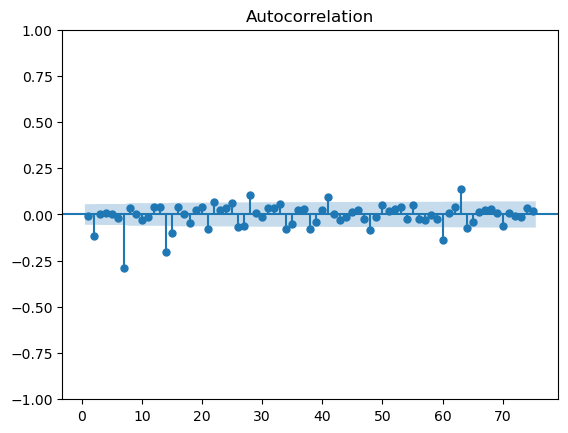

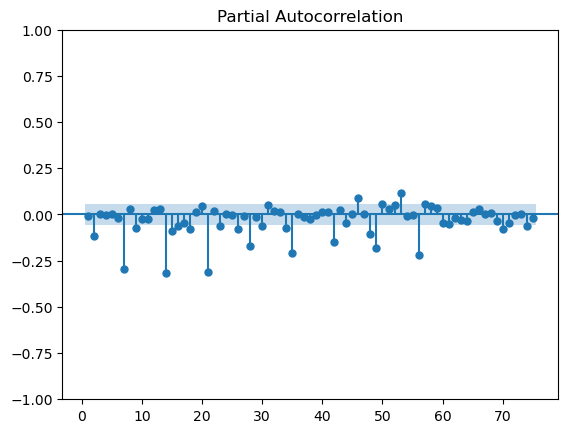

In [42]:
plot_acf(residual, lags=75, zero=False)
plot_pacf(residual, lags=75, zero=False)